In [1]:
import numpy as np
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
train_data = pd.read_csv('Lyrics-Genre-Train.csv', usecols = [3, 4], names = ['Genre', 'Lyrics'])
train_data.info()

test_data = pd.read_csv('Lyrics-Genre-Test-GroundTruth.csv', usecols = [3, 4], names = ['Genre', 'Lyrics'])
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18514 entries, 0 to 18513
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Genre   18514 non-null  object
 1   Lyrics  18514 non-null  object
dtypes: object(2)
memory usage: 289.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7936 entries, 0 to 7935
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Genre   7936 non-null   object
 1   Lyrics  7936 non-null   object
dtypes: object(2)
memory usage: 124.1+ KB


In [87]:
def compute_accuracy(model, X_valid, Y_valid, X_test, Y_test, model_name):
    
    #compute accuracy for the validation dataset
    print(model_name + " accuracy score on the validation dataset: ", accuracy_score(Y_valid, model.predict(X_valid)))

    #compute accuracy for the test dataset
    print(model_name + " accuracy score on the test dataset: ", accuracy_score(Y_test, model.predict(X_test)))

In [160]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

def run_models(X_train, Y_train, X_valid, Y_valid, X_test, Y_test, model_name):
    svm_mdl = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    svm_mdl.fit(X_train, Y_train)
    compute_accuracy(svm_mdl, X_valid, Y_valid, X_test, Y_test, model_name + " with SVM")
    
    rf_mdl = RandomForestClassifier(max_depth = 15, n_estimators = 350, random_state = 1)
    rf_mdl.fit(X_train, Y_train)
    compute_accuracy(rf_mdl, X_valid, Y_valid, X_test, Y_test, model_name + " with Random Forest")

    nb_mdl = GaussianNB()
    nb_mdl.fit(X_train, Y_train)
    compute_accuracy(nb_mdl, X_valid, Y_valid, X_test, Y_test, model_name + " with Naive Bayes")

    nn_mdl = MLPClassifier(random_state = 1, activation = "relu", solver = "adam", hidden_layer_sizes=(50,50, 25), max_iter = 300)
    nn_mdl.fit(X_train, Y_train)
    compute_accuracy(nb_mdl, X_valid, Y_valid, X_test, Y_test, model_name + " with Neural Networks")

<h2>Bag of words and SVM model - the baseline</h2>

The first approach used in order to classify the lyrics by genre is to use the classical Bag of words (BOW) technique togheter with the Support Vector Machine model. BOW is a natural language processing technique used to represent a colection of documents by the word present in it. All the words present in all the documents of the colection represents the vocabulary of known words; every document is represented as a list of numbers with the dimension equals with the number of the words from the vocabulary. So every number from the list represents the number of occurances of the i-th word (from the vocabulary) in the current document.

The input from the 'Lyrics' column is tokenized by words, the stopwords are removed, also the punctuation, all characters are normalized and a stemmer is applied to the resulted text. The next step is to pass this preprocessed input to the BOW model.The obtained output will be passed to the SVM model. Our purpoise is to see if the results obtained using BOW can be overtaken by other methods.

In [3]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def preprocess_text(data):
    #tokenize the lyrics into words
    data['tknz_lyrics'] = data['Lyrics'].apply(lambda row: word_tokenize(row))

     # remove all characters that are not letters
    all_lyrics = []
    for lyric in data['tknz_lyrics']:
        current_lyric = []
        for word in lyric:
            if word.isalpha():
                current_lyric.append(word.lower())
        all_lyrics.append(current_lyric)
    
    
    # remove the stop words (words that are not necesar in the meaning of a phrase)
    stop_words_eng = set(stopwords.words('english'))
    without_stop_words = []
    for lyric in all_lyrics:
        current_lyric = []
        for word in lyric:
            if word not in stop_words_eng:
                current_lyric.append(word)
        without_stop_words.append(current_lyric)
    
    #perform stemming step in order to truncate words to its root form 
    snowball_stemmer = nltk.stem.SnowballStemmer('english')
    stemmed_lyrics = []
    for lyric in without_stop_words:
        aux_lyric = []
        for word in lyric:
            aux_lyric.append(snowball_stemmer.stem(str(word)))
        stemmed_lyrics.append(aux_lyric)
        
    data['prepross_lyrics'] = stemmed_lyrics


In [4]:
preprocess_text(train_data)
preprocess_text(test_data)

In [5]:
print(np.shape(train_data))
print(np.shape(test_data))

(18514, 4)
(7936, 4)


In [5]:
# build Bag of words algorithm over the tokenized lyrics
def bow(training, test): 
    count_vect = CountVectorizer(max_features = 10000)
    count_data = count_vect.fit(training + test)
    training_out = count_vect.transform(training)
    test_out = count_vect.transform(test)
    return (training_out.toarray(), test_out.toarray())

In [6]:
def prepare_data_for_BOW():
    #prepare the data obtained by the preprocessing step in order to be passed to the model
    X_train = train_data['prepross_lyrics'].tolist()
    X_test = test_data['prepross_lyrics'].tolist()

    Y_train = train_data['Genre'].tolist()
    Y_test = test_data['Genre'].tolist()

    X_train =[" ".join(x) for x in X_train]
    X_test =[" ".join(x) for x in X_test]

    X_train, X_test = bow(X_train, X_test)
    print(X_train.shape)
    print(X_test.shape)

(18514, 10000)
(7936, 10000)


In [11]:
prepare_data_for_BOW()

In [14]:
#split the training dataset into training and validation
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [44]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
svm_mdl = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svm_mdl.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [46]:
from sklearn.metrics import accuracy_score

#compute accuracy for the validation dataset
print("BOW and SVM accuracy score on the validation dataset: ", accuracy_score(Y_valid, svm_mdl.predict(X_valid)))
      
#compute accuracy for the test dataset
print("BOW and SVM accuracy score on the test dataset: ", accuracy_score(Y_test, svm_mdl.predict(X_test)))

BOW and SVM accuracy score on the validation dataset:  0.31163921145017554
BOW and SVM accuracy score on the test dataset:  0.30934979838709675


<h2>TF-IDF method</h2>

Try the term frequency–inverse document frequency (TF-IDF) is a NLP method that has the role to find out how important is a word for a document. For every word of every document, a weight-factor is applied, so every word will receive a score computed on the frequency of that word in the corpus and offseted by the number of the documents from the corpus.

In [61]:
from sklearn.feature_extraction.text import TfidfTransformer

#apply td-idf to the bow method
tfidf_obj = TfidfTransformer(smooth_idf=False)
tfidf_test = tfidf_obj.fit_transform(X_test).toarray()
tfidf_train = tfidf_obj.fit_transform(X_train).toarray()
tfidf_valid = tfidf_obj.fit_transform(X_valid).toarray()
print(np.shape(tfidf_test))
print(np.shape(tfidf_train))
print(np.shape(tfidf_valid))

C:\Users\raradu\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1450: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1
C:\Users\raradu\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1450: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1
C:\Users\raradu\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1450: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


(7936, 10000)
(14811, 10000)
(3703, 10000)


The TF-IDF input will be passed to SVM, Random Forest, Naive Bayes and Neural Networks models in order to see on what model we can obtain a better accuracy.

In [114]:
run_models(tfidf_train, Y_train, tfidf_valid, Y_valid, tfidf_test, Y_test, "BOW and TD-IDF")

BOW and TD-IDF with SVM accuracy score on the validation dataset:  0.33864434242506075
BOW and TD-IDF with SVM accuracy score on the test dataset:  0.33845766129032256
BOW and TD-IDF with Random Forest accuracy score on the validation dataset:  0.33648393194706994
BOW and TD-IDF with Random Forest accuracy score on the test dataset:  0.3286290322580645
BOW and TD-IDF with Naive Bayes accuracy score on the validation dataset:  0.26357007831487983
BOW and TD-IDF with Naive Bayes accuracy score on the test dataset:  0.26764112903225806
BOW and TD-IDF with Neural Networks accuracy score on the validation dataset:  0.3219011612206319
BOW and TD-IDF with Neural Networks accuracy score on the test dataset:  0.3186743951612903


<b>Observation: </b>It seems that the TF-IDF method applied to the BOW input performs a little better than the simple BOW applied to the Lyrics input column. The results are not significant better, but SVM and Random Forest seems to perform a little better than the baseline (BOW and SVM).

In the above table, it can be observed all the obtained results for the BOW and TF-IDF methods:

| No.| Model |Validation Dataset Accuracy | Test Dataset Accuracy |
| --- | --- | --- | --- |
| 1. | SVM | 0.3386 | 0.3384 |
| 2. | Random Forest | 0.3364 | 0.3286 |
| 3. | Naive Bayes | 0.2635 | 0.2676 |
| 4. | Neural Network | 0.3219 | 0.3186 |

<h2>Word embeddings</h2>

After we tried the BOW model, it's time to move on to the next NLP technique that may lead to a better accuracy score. Now, the word embeddings method will be used. In word embeddings, the purpose is to transform every document (i.e. lyric of a song) in a vector of lenght N of real numbers. The difference between BOW vectors and word ebeddings vectors is that the vectors resulted in word embeddings contain some more information than the BOW vectors did. In word embeddings, the vector of a word can be closer or far to anoter word (in the sense of a distance); do this distance can say if some words are used togheter or not.

In [24]:
# prepare data for word embeddings
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer

def preprocess_text_for_wemb(data):
    #tokenize the lyrics into words
    data['tknz_lyrics'] = data['Lyrics'].apply(lambda row: word_tokenize(row))

     # remove all characters that are not letters
    all_lyrics = []
    for lyric in data['tknz_lyrics']:
        current_lyric = []
        for word in lyric:
            if word.isalpha():
                current_lyric.append(word.lower())
        all_lyrics.append(current_lyric)
    
    
    # remove the stop words (words that are not necesar in the meaning of a phrase)
    stop_words_eng = set(stopwords.words('english'))
    without_stop_words = []
    for lyric in all_lyrics:
        current_lyric = []
        for word in lyric:
            if word not in stop_words_eng:
                current_lyric.append(word)
        without_stop_words.append(current_lyric)
    
    #perform stemming step in order to truncate words to its root form 
    snowball_stemmer = nltk.stem.SnowballStemmer('english')
    stemmed_lyrics = []
    for lyric in without_stop_words:
        aux_lyric = []
        for word in lyric:
            aux_lyric.append(snowball_stemmer.stem(str(word)))
        stemmed_lyrics.append(aux_lyric)
    
    detokenized_lyrics = []
    for crnt in stemmed_lyrics:
        detokenized_lyrics.append(TreebankWordDetokenizer().detokenize(crnt))
        
    data['wemb_lyrics'] = detokenized_lyrics


In [25]:
preprocess_text_for_wemb(train_data)
preprocess_text_for_wemb(test_data)
print(np.shape(train_data))
print(np.shape(test_data))

(7936, 4)


,Genre,Lyrics,tknz_lyrics,wemb_lyrics
0,Genre,Lyrics,[Lyrics],lyric
1,Hip-Hop,Most folks spend their days daydreaming of fin...,"[Most, folks, spend, their, days, daydreaming,...",folk spend day daydream find clue whole life t...
2,Indie,Take your cold hands and put them on my face\n...,"[Take, your, cold, hands, and, put, them, on, ...",take cold hand put face sharpen axe crimin way...


In [29]:
import spacy

nlp = spacy.load('en_core_web_md')
def create_vects(text):
    doc = nlp(text)
    vector = doc.vector
    return vector

In [37]:
from IPython.display import clear_output

X_wemb_train = []
for index, row in train_data.iterrows():
    X_wemb_train.append(create_vects(row['wemb_lyrics']))

X_wemb_test = []
for index, row in test_data.iterrows():
    X_wemb_test.append(create_vects(row['wemb_lyrics']))

Y_wemb_train = train_data['Genre']
Y_wemb_test = test_data['Genre']
#split the training dataset into training and validation
from sklearn.model_selection import train_test_split
X_wemb_train, X_wemb_valid, Y_train_wemb, Y_wemb_valid = train_test_split(X_wemb_train, Y_wemb_train, test_size=0.2, random_state=42)

7935


In [101]:
run_models(X_wemb_train, Y_train_wemb, X_wemb_valid, Y_wemb_valid, X_wemb_test, Y_wemb_test, "Word Embeddings")

Word embeddings with SVM accuracy score on the validation dataset:  0.4080475290305158
Word embeddings with SVM accuracy score on the test dataset:  0.3978074596774194
Word embeddings with Random Forest accuracy score on the validation dataset:  0.3610586011342155
Word embeddings with Random Forest accuracy score on the test dataset:  0.3584929435483871
Word embeddings with Naive Bayes accuracy score on the validation dataset:  0.30812854442344045
Word embeddings with Naive Bayes accuracy score on the test dataset:  0.30279737903225806
Word embeddings with Neural Networks accuracy score on the validation dataset:  0.32298136645962733
Word embeddings with Neural Networks accuracy score on the test dataset:  0.32497479838709675


<b>Observation: </b> It seems that the word embeddings technique performs better than BOW and BOW togheter with TF-IDF. For all the tried models, the accuracy score is better, but the best results were obtained for the SVN model.

In the above table, it can be observed all the obtained results for the word embeddings method:

| No.| Model |Validation Dataset Accuracy | Test Dataset Accuracy |
| --- | --- | --- | --- |
| 1. | SVM | 0.4080 | 0.3978 |
| 2. | Random Forest | 0.3610 | 0.3584 |
| 3. | Naive Bayes | 0.3081 | 0.3027 |
| 4. | Neural Network | 0.3229 | 0.3249 |

After the clasical methods were applied, we will try to optimize our results by adding additional features to our model.

<h3>Remove the records that contain non-english lyrics</h3>

In [69]:
train_data.name = 'train'
test_data.name = 'test'
print(train_data.name)
print(test_data.name)

train
test


In [75]:
def create_only_english_data(data):
    eng_data_list = []
    non_eng_cnt = 0
    for index, row in data.iterrows():
        det_lang = detect(row['Lyrics'])
        if det_lang == 'en':
            crnt_row = row.to_dict()
            eng_data_list.append(crnt_row)
        else:
            non_eng_cnt += 1
            print ("Found " + det_lang + " in " + data.name)
    eng_data = pd.DataFrame(eng_data_list, columns = ['Genre', 'Lyrics'])
    return non_eng_cnt, eng_data

train_non_eng, eng_train_data = create_only_english_data(train_data)
test_non_eng, eng_test_data = create_only_english_data(test_data)

Found cy in train
Found fi in train
Found es in train
Found cy in train
Found it in train
Found fr in train
Found hr in train
Found fr in train
Found fr in train
Found sw in train
Found et in train
Found so in train
Found cy in train
Found sl in train
Found es in train
Found tr in train
Found cy in test
Found cy in test
Found sw in test
Found af in test
Found cy in test
Found cy in test
Found nl in test


In [77]:
print(eng_train_data.info())
print(eng_test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18498 entries, 0 to 18497
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Genre   18498 non-null  object
 1   Lyrics  18498 non-null  object
dtypes: object(2)
memory usage: 289.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7929 entries, 0 to 7928
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Genre   7929 non-null   object
 1   Lyrics  7929 non-null   object
dtypes: object(2)
memory usage: 124.0+ KB
None


<AxesSubplot:>

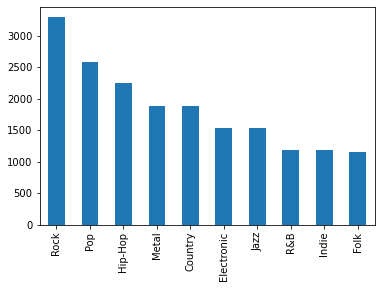

In [79]:
eng_train_data['Genre'].value_counts().plot(kind='bar')

As can be oberved on the previous graphic, we cannot say that the data is umblanced. Because the porpose of this project is to find good methods to find the musical genre (but the accuracy of the models is not so important) we will not use balancing data techniques.

Next, we will apply word embedding for the resulted dataset that contains only english lycrics in order to see if we will obtain better results.

In [81]:
preprocess_text_for_wemb(eng_train_data)
preprocess_text_for_wemb(eng_test_data)


X_eng_wemb_train = []
for index, row in eng_train_data.iterrows():
    X_eng_wemb_train.append(create_vects(row['wemb_lyrics']))

X_eng_wemb_test = []
for index, row in eng_test_data.iterrows():
    X_eng_wemb_test.append(create_vects(row['wemb_lyrics']))

Y_eng_wemb_train = eng_train_data['Genre']
Y_eng_wemb_test = eng_test_data['Genre']

#split the training dataset into training and validation
from sklearn.model_selection import train_test_split
X_eng_wemb_train, X_eng_wemb_valid, Y_eng_wemb_train, Y_wemb_valid = train_test_split(X_eng_wemb_train, Y_eng_wemb_train, test_size=0.2, random_state=42)

In [90]:
run_models(X_eng_wemb_train, Y_eng_wemb_train, X_eng_wemb_valid, Y_wemb_valid, X_eng_wemb_test, Y_eng_wemb_test, "Only English lyrics and Word Embeddings")

Only English lyrics and Word Embeddings with SVM accuracy score on the validation dataset:  0.4072972972972973
Only English lyrics and Word Embeddings with SVM accuracy score on the test dataset:  0.39714970361962415
Only English lyrics and Word Embeddings with Random Forest accuracy score on the validation dataset:  0.3645945945945946
Only English lyrics and Word Embeddings with Random Forest accuracy score on the test dataset:  0.3618362971370917
Only English lyrics and Word Embeddings with Naive Bayes accuracy score on the validation dataset:  0.2997297297297297
Only English lyrics and Word Embeddings with Naive Bayes accuracy score on the test dataset:  0.2995333585571951


C:\Users\raradu\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Only English lyrics and Word Embeddings with Neural Networks accuracy score on the validation dataset:  0.2997297297297297
Only English lyrics and Word Embeddings with Neural Networks accuracy score on the test dataset:  0.2995333585571951


<b>Observation: </b> It seems that the word embeddings technique applied only for the lycrics of english songs is not an improvement; the obtained accuracy is a little lower than the previous one.

In the above table, it can be observed all the obtained results for the word embeddings method applied only for the english songs:

| No.| Model |Validation Dataset Accuracy | Test Dataset Accuracy |
| --- | --- | --- | --- |
| 1. | SVM | 0.4072 | 0.3971 |
| 2. | Random Forest |0.3645 | 0.3618 |
| 3. | Naive Bayes | 0.2997 | 0.2995 |
| 4. | Neural Network | 0.2997 | 0.2995 |

<h3>The stopwords</h3>

Next we will use the stopwords in the word embedding technique. For some musical genre, the stopwords can be important as it can be a defining feature of that musical genre (i.e. for Rap music, the artists are using more stopwords that in Folk). For a better consistency we will continue to use only the dataset that contains only english songs.

In [95]:
def remove_punctuation(data):
    all_lyrics = []
    for lyric in data['tknz_lyrics']:
        current_lyric = []
        for word in lyric:
            if word.isalpha():
                current_lyric.append(word.lower())
        all_lyrics.append(current_lyric)
    return all_lyrics

def remove_stopwords(all_lyrics):
    stop_words_eng = set(stopwords.words('english'))
    without_stop_words = []
    for lyric in all_lyrics:
        current_lyric = []
        for word in lyric:
            if word not in stop_words_eng:
                current_lyric.append(word)
        without_stop_words.append(current_lyric)
    return without_stop_words

def apply_steammer(all_lyrics):
    snowball_stemmer = nltk.stem.SnowballStemmer('english')
    stemmed_lyrics = []
    for lyric in all_lyrics:
        aux_lyric = []
        for word in lyric:
            aux_lyric.append(snowball_stemmer.stem(str(word)))
        stemmed_lyrics.append(aux_lyric)
    return stemmed_lyrics

def preprocess_text_for_wemb_with_stopwords(data):
    without_punctuation = remove_punctuation(data)
    stemmer_applied = apply_steammer(without_punctuation)
    
    detokenized_lyrics = []
    for crnt in stemmer_applied:
        detokenized_lyrics.append(TreebankWordDetokenizer().detokenize(crnt))
        
    data['wemb_lyrics_with_stopwords'] = detokenized_lyrics

preprocess_text_for_wemb_with_stopwords(eng_train_data)
preprocess_text_for_wemb_with_stopwords(eng_test_data)

In [103]:
X_eng_stp_wemb_train = []
for index, row in eng_train_data.iterrows():
    X_eng_stp_wemb_train.append(create_vects(row['wemb_lyrics_with_stopwords']))

X_eng_stp_wemb_test = []
for index, row in eng_test_data.iterrows():
    X_eng_stp_wemb_test.append(create_vects(row['wemb_lyrics_with_stopwords']))

Y_eng_stp_wemb_train = eng_train_data['Genre']
Y_eng_stp_wemb_test = eng_test_data['Genre']

#split the training dataset into training and validation
from sklearn.model_selection import train_test_split
X_eng_stp_wemb_train, X_eng_stp_wemb_valid, Y_eng_stp_wemb_train, Y_eng_stp_wemb_valid = train_test_split(X_eng_stp_wemb_train, Y_eng_stp_wemb_train, test_size=0.2, random_state=42)

In [164]:
run_models(X_eng_stp_wemb_train, Y_eng_stp_wemb_train, X_eng_stp_wemb_valid, Y_eng_stp_wemb_valid, X_eng_stp_wemb_test, Y_eng_stp_wemb_test, "Lyric with stopwords and Word Embeddings")

Lyric with stopwords and Word Embeddings with SVM accuracy score on the validation dataset:  0.3908108108108108
Lyric with stopwords and Word Embeddings with SVM accuracy score on the test dataset:  0.39525791398663135
Lyric with stopwords and Word Embeddings with Random Forest accuracy score on the validation dataset:  0.34324324324324323
Lyric with stopwords and Word Embeddings with Random Forest accuracy score on the test dataset:  0.3527557068987262
Lyric with stopwords and Word Embeddings with Naive Bayes accuracy score on the validation dataset:  0.2691891891891892
Lyric with stopwords and Word Embeddings with Naive Bayes accuracy score on the test dataset:  0.26913860512044396


C:\Users\raradu\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Lyric with stopwords and Word Embeddings with Neural Networks accuracy score on the validation dataset:  0.2691891891891892
Lyric with stopwords and Word Embeddings with Neural Networks accuracy score on the test dataset:  0.26913860512044396


<b>Observation: </b> It seems that the word embeddings technique applied for the lycrics of english songs with the stopwords is worst than the previous trying.

In the above table, it can be observed all the obtained results for the word embeddings method applied only for the english songs with stopwords:

| No.| Model |Validation Dataset Accuracy | Test Dataset Accuracy |
| --- | --- | --- | --- |
| 1. | SVM | 0.3908 | 0.3952 |
| 2. | Random Forest | 0.3432 | 0.3527 |
| 3. | Naive Bayes | 0.2691 | 0.2691 |
| 4. | Neural Network | 0.2691 | 0.2691 |

<h3>The punctuation</h3>

We will try next to run the models on the english songs dataset using also the punctuation. In some music genre the punctuation can be used more as it can express the feelings of the artist.

In [111]:
def preprocess_text_for_wemb_with_stopwords_and_punctuation(data):
    stemmer_applied = apply_steammer(data['tknz_lyrics'])
    
    detokenized_lyrics = []
    for crnt in stemmer_applied:
        detokenized_lyrics.append(TreebankWordDetokenizer().detokenize(crnt))
        
    data['wemb_lyrics_with_stopwords_punctuation'] = detokenized_lyrics

preprocess_text_for_wemb_with_stopwords_and_punctuation(eng_train_data)
preprocess_text_for_wemb_with_stopwords_and_punctuation(eng_test_data)

In [115]:
eng_train_data.head(4)

,Genre,Lyrics,tknz_lyrics,wemb_lyrics,wemb_lyrics_with_stopwords,wemb_lyrics_with_stopwords_punctuation
0,Metal,"I am a night in to the darkness, only soul los...","[I, am, a, night, in, to, the, darkness, ,, on...",night dark soul lost walk throught night fores...,i am a night in to the dark onli soul lost wit...,"i am a night in to the dark, onli soul lost wi..."
1,Hip-Hop,"Yeah\nSometimes, i just wanna fly away.\nThey ...","[Yeah, Sometimes, ,, i, just, wan, na, fly, aw...",yeah sometim wannafli away say ca ca skate ca ...,yeah sometim i just wannafli away they say i c...,"yeah sometim, i just wannafli away . they say ..."
2,Metal,Do you work hard?\nDo you work hard?\nYou don'...,"[Do, you, work, hard, ?, Do, you, work, hard, ...",work hard work hard chicago work hard tri hard...,do you work hard do you work hard you do you d...,do you work hard? do you work hard? you don't!...
3,Hip-Hop,You know what? I'm destined to be the last man...,"[You, know, what, ?, I, 'm, destined, to, be, ...",know destin last man standin care mappin escap...,you know what i destin to be the last man stan...,you know what? i'm destin to be the last man s...


In [112]:
X_eng_stp_pct_wemb_train = []
for index, row in eng_train_data.iterrows():
    X_eng_stp_pct_wemb_train.append(create_vects(row['wemb_lyrics_with_stopwords_punctuation']))

X_eng_stp_pct_wemb_test = []
for index, row in eng_test_data.iterrows():
    X_eng_stp_pct_wemb_test.append(create_vects(row['wemb_lyrics_with_stopwords_punctuation']))

Y_eng_stp_pct_wemb_train = eng_train_data['Genre']
Y_eng_stp_pct_wemb_test = eng_test_data['Genre']

#split the training dataset into training and validation
from sklearn.model_selection import train_test_split
X_eng_stp_pct_wemb_train, X_eng_stp_pct_wemb_valid, Y_eng_stp_pct_wemb_train, Y_eng_stp_pct_wemb_valid = train_test_split(X_eng_stp_pct_wemb_train, Y_eng_stp_pct_wemb_train, test_size=0.2, random_state=42)

In [163]:
run_models(X_eng_stp_pct_wemb_train, Y_eng_stp_pct_wemb_train, X_eng_stp_pct_wemb_valid, Y_eng_stp_pct_wemb_valid, X_eng_stp_pct_wemb_test, Y_eng_stp_pct_wemb_test, "Lyric with stopwords and punctuation and Word Embeddings")

Lyric with stopwords and punctuation and Word Embeddings with SVM accuracy score on the validation dataset:  0.4002702702702703
Lyric with stopwords and punctuation and Word Embeddings with SVM accuracy score on the test dataset:  0.4078698448732501
Lyric with stopwords and punctuation and Word Embeddings with Random Forest accuracy score on the validation dataset:  0.3564864864864865
Lyric with stopwords and punctuation and Word Embeddings with Random Forest accuracy score on the test dataset:  0.3589355530331694
Lyric with stopwords and punctuation and Word Embeddings with Naive Bayes accuracy score on the validation dataset:  0.27918918918918917
Lyric with stopwords and punctuation and Word Embeddings with Naive Bayes accuracy score on the test dataset:  0.2813721780804641


C:\Users\raradu\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Lyric with stopwords and punctuation and Word Embeddings with Neural Networks accuracy score on the validation dataset:  0.27918918918918917
Lyric with stopwords and punctuation and Word Embeddings with Neural Networks accuracy score on the test dataset:  0.2813721780804641


<b>Observation: </b> It seems that if we are adding the punctuations we are obtaining better results than the previous trying when we added the stopwords to the word embedding.

In the above table, it can be observed all the obtained results for the word embeddings method applied only for the english songs with stopwords and punctuation:

| No.| Model |Validation Dataset Accuracy | Test Dataset Accuracy |
| --- | --- | --- | --- |
| 1. | SVM | 0.4002 | 0.4078 |
| 2. | Random Forest | 0.3564 | 0.3589 |
| 3. | Naive Bayes | 0.2791 | 0.2813 |
| 4. | Neural Network | 0.2791 | 0.2813 |


<h3>Steamming process</h3>

As the results obtained for the case in which we don't remove stopwords and punctuation we will next try to remove them but not perform the steamming process.

In [121]:
def preprocess_text_for_wemb_without_steamming(data):
     detokenized_lyrics = []
    for crnt in data['Lyrics']:
        detokenized_lyrics.append(TreebankWordDetokenizer().detokenize(crnt))

    data['wemb_lyrics_without_steamming'] = detokenized_lyrics

preprocess_text_for_wemb_without_steamming(eng_train_data)
preprocess_text_for_wemb_without_steamming(eng_test_data)

In [123]:
X_eng_stm_wemb_train = []
for index, row in eng_train_data.iterrows():
    X_eng_stm_wemb_train.append(create_vects(row['wemb_lyrics_without_steamming']))

X_eng_stm_wemb_test = []
for index, row in eng_test_data.iterrows():
    X_eng_stm_wemb_test.append(create_vects(row['wemb_lyrics_without_steamming']))

Y_eng_stm_wemb_train = eng_train_data['Genre']
Y_eng_stm_wemb_test = eng_test_data['Genre']

#split the training dataset into training and validation
from sklearn.model_selection import train_test_split
X_eng_stm_wemb_train, X_eng_stm_wemb_valid, Y_eng_stm_wemb_train, Y_eng_stm_wemb_valid = train_test_split(X_eng_stm_wemb_train, Y_eng_stm_wemb_train, test_size=0.2, random_state=42)

In [162]:
run_models(X_eng_stm_wemb_train, Y_eng_stm_wemb_train, X_eng_stm_wemb_valid, Y_eng_stm_wemb_valid, X_eng_stm_wemb_test, Y_eng_stm_wemb_test, "Lyric without steamming and Word Embeddings")

Lyric without steamming and Word Embeddings with SVM accuracy score on the validation dataset:  0.4245945945945946
Lyric without steamming and Word Embeddings with SVM accuracy score on the test dataset:  0.41341909446336234
Lyric without steamming and Word Embeddings with Random Forest accuracy score on the validation dataset:  0.37405405405405406
Lyric without steamming and Word Embeddings with Random Forest accuracy score on the test dataset:  0.37406987009711185
Lyric without steamming and Word Embeddings with Naive Bayes accuracy score on the validation dataset:  0.3108108108108108
Lyric without steamming and Word Embeddings with Naive Bayes accuracy score on the test dataset:  0.30911842603102535


C:\Users\raradu\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Lyric without steamming and Word Embeddings with Neural Networks accuracy score on the validation dataset:  0.3108108108108108
Lyric without steamming and Word Embeddings with Neural Networks accuracy score on the test dataset:  0.30911842603102535


<b>Observation: </b> It seems that if we are removing the steamming process we are obtaining better than on the previous trying:

| No.| Model |Validation Dataset Accuracy | Test Dataset Accuracy |
| --- | --- | --- | --- |
| 1. | SVM | 0.4245 | 0.4134 |
| 2. | Random Forest | 0.3740 | 0.3740 |
| 3. | Naive Bayes | 0.3108 | 0.2996 |
| 4. | Neural Network | 0.3005 | 0.3091 |


<h3>Adding new features to the dataset</h3>

We will try to add new information to the dataset. For some music genre, the punctuation can still be a good indicator of the genre so we will add a feature that represents the punctuation counts from lyric.

A new possible feature could be the number of words per line, as in some music genre the artists have a good word speed per lines (i.e. rap, pop) than for others (i.e. folk, jazz). The words per line will be defined as the number of words divided by the number of lines.

These new features will be added to the coumn were the lyrics were added with stopwords, punctuation and without the performing of the steamming process.

In [138]:
def count_punctuation(data):
    pct_count = 0
    pct_count_list = []
    count = lambda chr1, chr2: len(list(filter(lambda ch: ch in chr2, chr1)))
    for crnt in data['Lyrics']:
        pct_count = count(crnt, string.punctuation)
        pct_count_list.append(pct_count)
        pct_count = 0
    data['punctuation_count'] = pct_count_list

count_punctuation(eng_train_data)
count_punctuation(eng_test_data)    

In [151]:
def count_words_per_line(data):
    lines_count = 0
    words_count = 0
    words_per_line = 0
    words_per_line_list = []
    for crnt in data['Lyrics']:
        words_count = sum([i.strip(string.punctuation).isalpha() for i in crnt.split()])
        lines_count = crnt.count('\n')
        if (lines_count != 0):
            words_per_line = round(words_count / lines_count)
        else:
            words_per_line = round(words_count / 1)
        words_per_line_list.append(words_per_line)
        lines_count = 0
        words_count = 0
        words_per_line = 0
    data['words_per_lines'] = words_per_line_list
count_words_per_line(eng_train_data)
count_words_per_line(eng_test_data)  

In [153]:
X_eng_wemb_train = []
for index, row in eng_train_data.iterrows():
    X_eng_wemb_train.append(create_vects(row['wemb_lyrics_without_steamming']))

X_eng_wemb_test = []
for index, row in eng_test_data.iterrows():
    X_eng_wemb_test.append(create_vects(row['wemb_lyrics_without_steamming']))
    
Y_eng_wemb_train = eng_train_data['Genre']
Y_eng_wemb_test = eng_test_data['Genre']


In [154]:
X_data_train = pd.DataFrame(X_eng_wemb_train)
X_data_test = pd.DataFrame(X_eng_wemb_test)

X_data_train['punctuation_count'] = eng_train_data['punctuation_count']
X_data_test['punctuation_count'] = eng_test_data['punctuation_count']

X_data_train['words_per_lines'] = eng_train_data['words_per_lines']
X_data_test['words_per_lines'] = eng_test_data['words_per_lines']

X_data_train.info()
X_data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18498 entries, 0 to 18497
Columns: 302 entries, 0 to words_per_lines
dtypes: float32(300), int64(2)
memory usage: 21.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7929 entries, 0 to 7928
Columns: 302 entries, 0 to words_per_lines
dtypes: float32(300), int64(2)
memory usage: 9.2 MB


In [157]:
#split the training dataset into training and validation
from sklearn.model_selection import train_test_split
X_data_train, X_data_valid, Y_eng_wemb_train, Y_data_valid = train_test_split(X_data_train, Y_eng_wemb_train, test_size=0.2, random_state=42)

In [170]:
run_models(X_data_train, Y_eng_wemb_train, X_data_valid, Y_data_valid, X_data_test, Y_eng_wemb_test, "Added Words Per Line and Punctuation Count features and Word Embeddings")

Added Words Per Line and Punctuation Count features and Word Embeddings with SVM accuracy score on the validation dataset:  0.4254054054054054
Added Words Per Line and Punctuation Count features and Word Embeddings with SVM accuracy score on the test dataset:  0.416097890074354
Added Words Per Line and Punctuation Count features and Word Embeddings with Random Forest accuracy score on the validation dataset:  0.38134486467886487
Added Words Per Line and Punctuation Count features and Word Embeddings with Random Forest accuracy score on the test dataset:  0.38507709456836537
Added Words Per Line and Punctuation Count features and Word Embeddings with Naive Bayes accuracy score on the validation dataset:  0.31548743243765245
Added Words Per Line and Punctuation Count features and Word Embeddings with Naive Bayes accuracy score on the test dataset:  0.3106623423369908
Added Words Per Line and Punctuation Count features and Word Embeddings with Neural Networks accuracy score on the validat

<b>Observation: </b> It seems that these new featres are not a great improvement to the model, but still performs a little better than the previous trying:

| No.| Model |Validation Dataset Accuracy | Test Dataset Accuracy |
| --- | --- | --- | --- |
| 1. | SVM | 0.4254 | 0.4160 |
| 2. | Random Forest | 0.3813 | 0.3154 |
| 3. | Naive Bayes | 0.3154 | 0.3106 |
| 4. | Neural Network | 0.3234 | 0.3678 |


<h3>Conclusions</h3>

Regarding all the NLP used techniques, the word embeddings technique was better than the bag of words for the given dataset.

In this project, we used 4 machine learning models: SVM, Random Forest, Naive Bayes, and Neural Networks. The hiper parameters were tuned after some trying, but not with the best possible values as the accuracy of the models was not the scope of this project. It was observed that the SVM model performs better than the others for the given dataset.

Regarding the preprocessing step, an interesting fact is that we obtained better results if we don't apply the classical text preprocessing steps (removal of stopwords and punctuation and the process of steamming).  

In the end, we added two additional features to the dataset: Punctuation count and Words per line. Because we are trying to classify music genres, these two features can be decisive in distinguishing between different music types.